# Evaluating kinetics in FBA-gd

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import dill

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

In [2]:
os.getcwd()

'/Users/cyrus/vivarium-ecoli'

# Import sim output

out/fbagd/kinetics_10_2022-08-22

In [3]:
time = '10'
date = '2022-09-13'
entry = f'kinetics_{time}_{date}'
folder = f'out/fbagd/{entry}/'

In [4]:
output = np.load(folder + 'output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [5]:
f = open(folder + 'agent.pkl', 'rb')
agent = dill.load(f)
f.close()

In [6]:
s_matrix = agent['ecoli-metabolism-gradient-descent'].model.network.s_matrix
stoichiometry = agent['ecoli-metabolism-gradient-descent'].stoichiometry

In [7]:
fba.keys()

dict_keys(['estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'target_kinetic_fluxes', 'target_kinetic_bounds', 'estimated_exchange_dmdt', 'estimated_intermediate_dmdt', 'maintenance_target', 'solution_fluxes', 'solution_dmdt', 'solution_residuals', 'time_per_step'])

# Runtime, mass

In [8]:
times = [time - fba['time_per_step'][1] for time in fba['time_per_step'][1:]]
time_diff = [(times[i+1] - times[i])/2 for i in range(len(times)-1)]
index = [i for i in range(len(times)-1)]

In [9]:
# #f = sns.lineplot(index, time_diff)
# # f.hlines(y=[2,4], xmin=0, xmax=500)
# running_mean = np.convolve(time_diff, np.ones(10), 'valid') / 10
# f = sns.lineplot(index[0:len(running_mean)], running_mean)
# f.set_xlabel('Simulation step')
# f.set_ylabel('Real second to simulation second')

<AxesSubplot:>

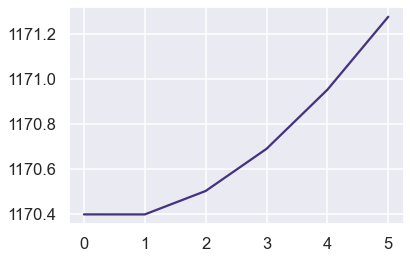

In [10]:
sns.lineplot(x=[i for i in range(len(mass['cell_mass']))],y=mass['cell_mass'])

# Molecule exchanges

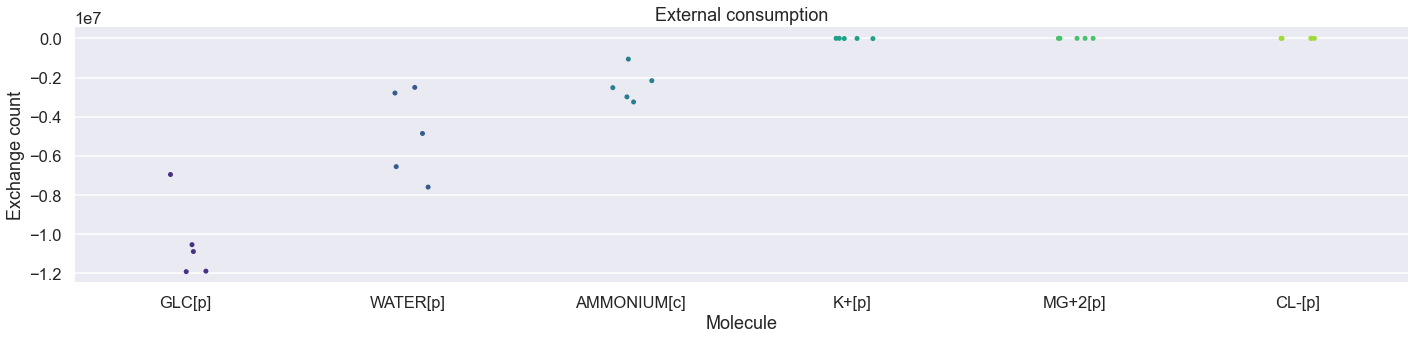

In [11]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='External consumption')


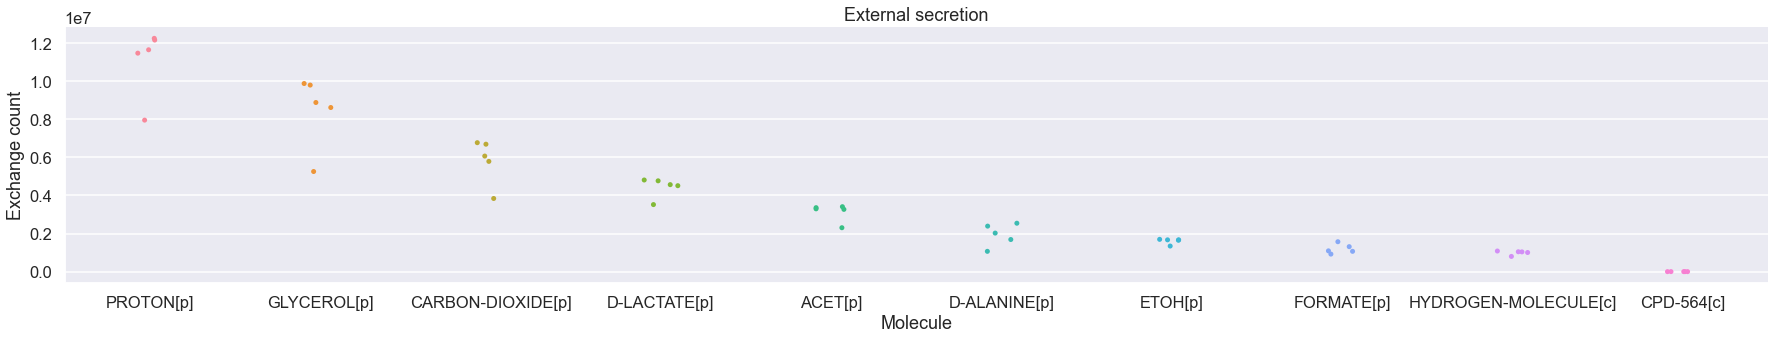

In [12]:
sorted_exchange = pd.DataFrame(fba['estimated_exchange_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:10].melt(var_name="Molecule", value_name="Exchange count"), aspect=5).set(title='External secretion')


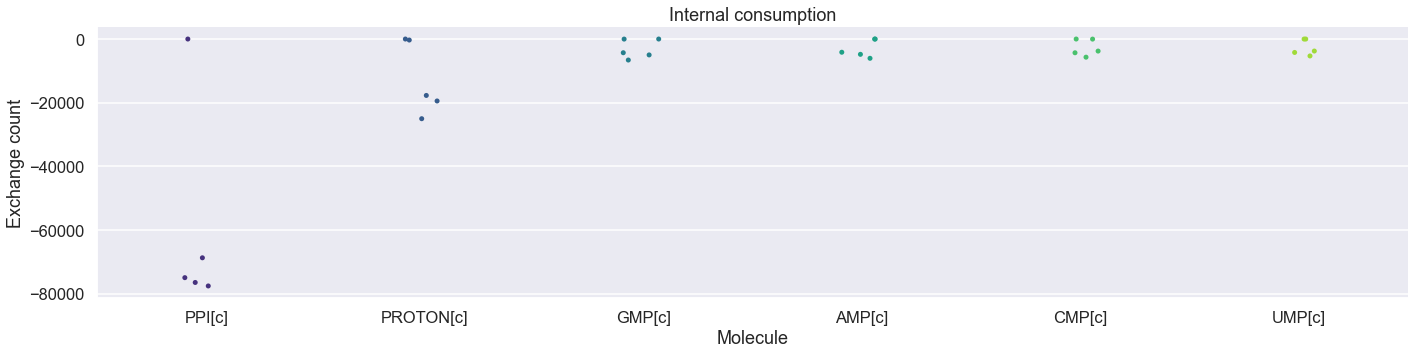

In [13]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal consumption')

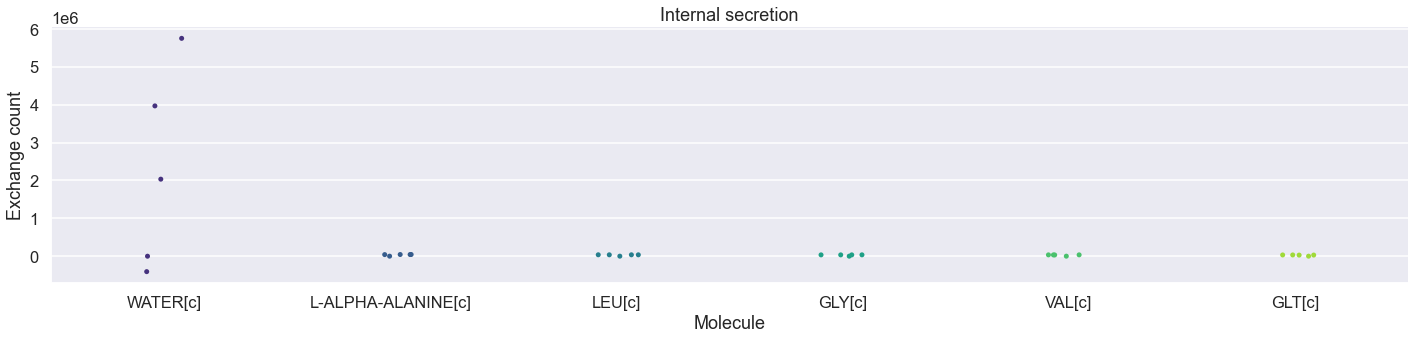

In [14]:
sorted_exchange = pd.DataFrame(fba['target_homeostatic_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Internal secretion')


# Meeting objectives

## Homeostatic

In [15]:
df1 = pd.DataFrame(fba['estimated_homeostatic_dmdt'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')
df1.head()

,index,timestep,update
0,2-3-DIHYDROXYBENZOATE[c],0,18.0
1,2-KETOGLUTARATE[c],0,-12.0
2,2-PG[c],0,3.0
3,2K-4CH3-PENTANOATE[c],0,23.0
4,4-AMINO-BUTYRATE[c],0,-0.0


In [16]:
df2 = pd.DataFrame(fba['target_homeostatic_dmdt'])
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df2.head()

,index,timestep,target
0,2-3-DIHYDROXYBENZOATE[c],0,0.0
1,2-KETOGLUTARATE[c],0,0.0
2,2-PG[c],0,0.0
3,2K-4CH3-PENTANOATE[c],0,0.0
4,4-AMINO-BUTYRATE[c],0,0.0


In [17]:
df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])
# df3[df3['timestep'] == 900].T
df3

df3['update'] = df3['update'].abs() 
df3['target'] = df3['target'].abs() 

df3['update'] = np.log10(df3['update'])
df3['target'] = np.log10(df3['target'])

df3 = df3.replace([np.inf, -np.inf], 0)

df3['diff'] = df3['target'] - df3['update']

df3.head()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,update,target,diff
0,2-3-DIHYDROXYBENZOATE[c],0,1.255273,0.0,-1.255273
1,2-KETOGLUTARATE[c],0,1.079181,0.0,-1.079181
2,2-PG[c],0,0.477121,0.0,-0.477121
3,2K-4CH3-PENTANOATE[c],0,1.361728,0.0,-1.361728
4,4-AMINO-BUTYRATE[c],0,0.000000,0.0,0.000000


In [18]:
df3_subset = df3[df3['timestep'].isin([0, 1, 2, 10, 24, 100])]

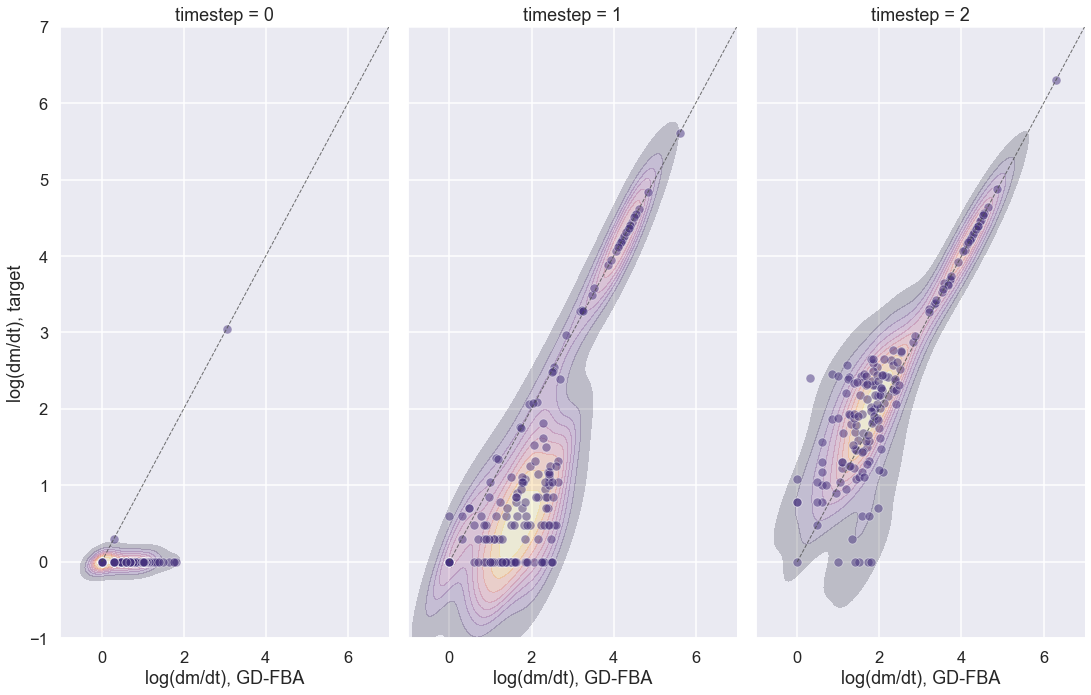

In [19]:
g = sns.FacetGrid(df3_subset, col="timestep", col_wrap=6, aspect=0.5, height=10, xlim=(-1,7), ylim=(-1,7))
g.map(sns.kdeplot, "update", "target", cmap="inferno", alpha=0.2, fill=True)
g.map(sns.scatterplot, "update", "target", alpha=0.5)
g.set_axis_labels("log(dm/dt), GD-FBA","log(dm/dt), target")

for ax in g.axes:
    ax.plot([0, 9], [0, 9], linewidth=1,  linestyle='--', color='.3', alpha=0.8)
    

plt.margins(0,0)

### Are the outliers a problem?

<AxesSubplot:>

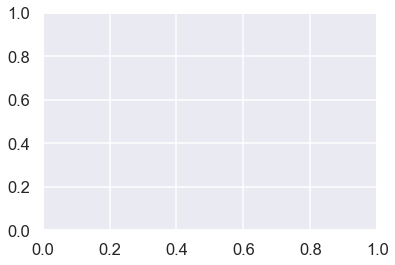

In [20]:
df4 = df3.loc[df3['timestep'] == 25].reset_index(drop=True)
outliers = list(df4.loc[df4['diff']>1, 'index'])

sns.histplot(x='diff', data=df4)

In [21]:
bulk.loc[35:40, outliers]

""


In [22]:
pd.DataFrame(fba['target_homeostatic_dmdt']).loc[35:40, outliers]

""


Doesn't look like they're going into negative at least. Are they being used? I would guess that they're just not incentivized enough to reach their target completely, since all the diffs are in the 10-100 range. Magnitudes smaller than their conc. 

## Futile cycling objective

In [23]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
cycle = fluxes.loc[:,['RXN0-7209-GLC//GLC.9.','RXN0-7247-GLC//GLC.9.']]
cycle.head()

cycle.columns = ['A->B', 'B->A']

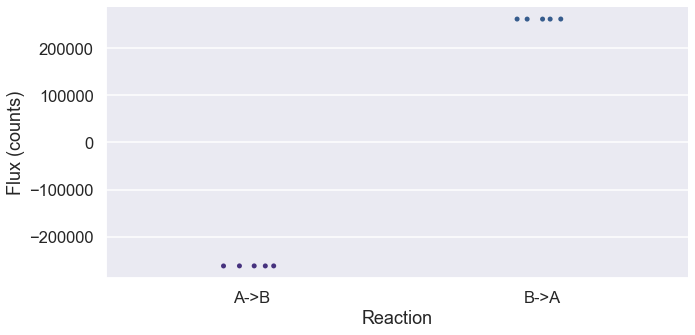

In [24]:
sns.catplot(y="Flux (counts)", x="Reaction", data=cycle.melt(var_name="Reaction", value_name="Flux (counts)"), aspect=2)

Could use improvement.

## Glucose uptake

In [25]:
glucose_transport_reactions = ['TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//ALPHA-GLC-6-P/PTSH-MONOMER.52.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//D-glucopyranose-6-phosphate/PTSH-MONOMER.66.',
                               'TRANS-RXN-157-PTSH-PHOSPHORYLATED/GLC//GLC-6-P/PTSH-MONOMER.46.',
                               'RXN0-7077-GLC/PROTON//ALPHA-GLUCOSE/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//Glucopyranose/PROTON.33.',
                               'RXN0-7077-GLC/PROTON//GLC/PROTON.23.',
                               'TRANS-RXN0-574-GLC//GLC.9.',
                               'TRANS-RXN0-574-GLC//Glucopyranose.19.',
                               'TRANS-RXN-320-GLC/ATP/WATER//ALPHA-GLUCOSE/ADP/Pi/PROTON.43.',
                               'TRANS-RXN-320-GLC/ATP/WATER//GLC/ADP/Pi/PROTON.33.',
                               'TRANS-RXN-320-GLC/ATP/WATER//Glucopyranose/ADP/Pi/PROTON.43.']


In [26]:
fluxes = pd.DataFrame(fba['estimated_fluxes'])
influx = fluxes.loc[:,glucose_transport_reactions]
influx.head()

influx.columns = ['PTS-1', 'PTS-2', 'PTS-3', 'DIF-1', 'DIF-2', 'DIF-3', 'DIF-4', 'DIF-5', 'DUP-1', 'DUP-2', 'DUP-3']

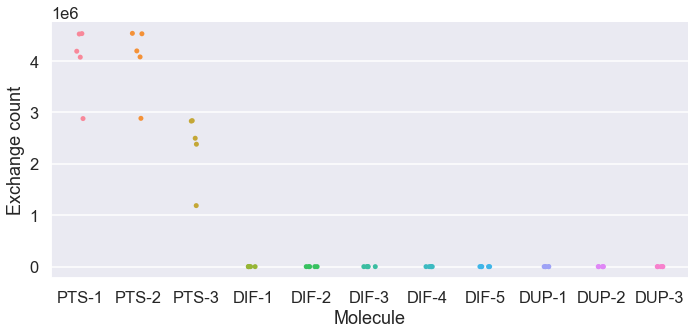

In [27]:
sns.catplot(y="Exchange count", x="Molecule", data=influx.melt(var_name="Molecule", value_name="Exchange count"), aspect=2)

Works as intended.

## Steady state objective

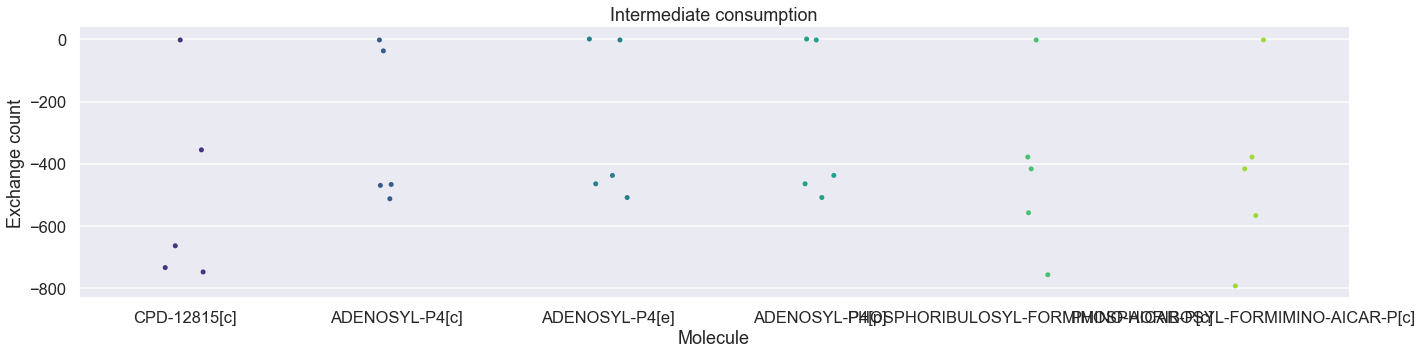

In [28]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Intermediate consumption')

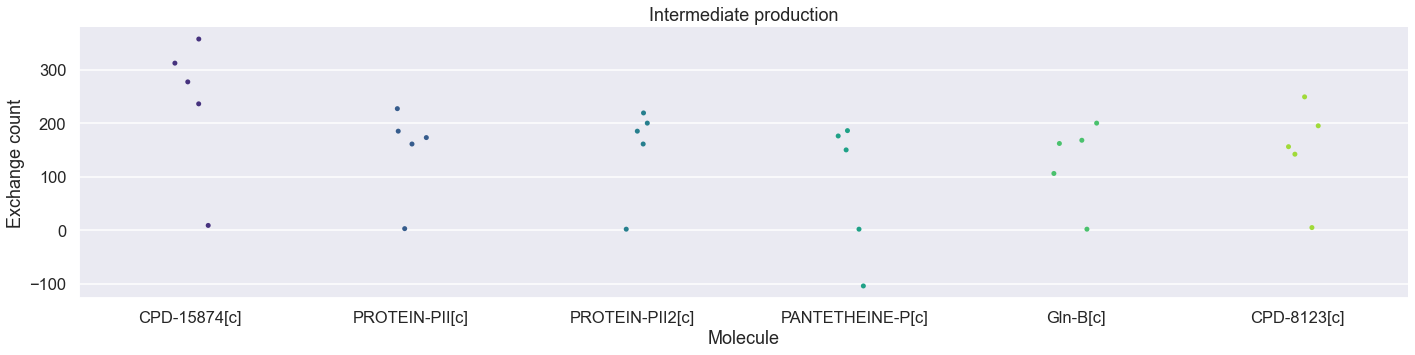

In [29]:
sorted_exchange = pd.DataFrame(fba['estimated_intermediate_dmdt']).sort_values(by=3, axis=1, ascending=False)
sns.catplot(y="Exchange count", x="Molecule", data=sorted_exchange.iloc[:,0:6].melt(var_name="Molecule", value_name="Exchange count"), aspect=4).set(title='Intermediate production')

In [30]:
kinetic_substrates = agent['ecoli-metabolism-gradient-descent'].kinetic_constraint_substrates
kinetic_substrates[0:5]

['2-3-DIHYDROXYBENZOATE[c]',
 '2-KETOGLUTARATE[c]',
 '4-AMINO-BUTYRATE[c]',
 '4-hydroxybenzoate[c]',
 'ACETYL-COA[c]']

In [31]:
homeostatic_objective = list(agent['ecoli-metabolism-gradient-descent'].homeostatic_objective.keys())
homeostatic_objective[0:5]

['2-3-DIHYDROXYBENZOATE[c]',
 '2-KETOGLUTARATE[c]',
 '2-PG[c]',
 '2K-4CH3-PENTANOATE[c]',
 '4-AMINO-BUTYRATE[c]']

In [32]:
len(set(kinetic_substrates).intersection(set(homeostatic_objective)))

91

In [33]:
len(kinetic_substrates)

91

## Maintenance objective

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

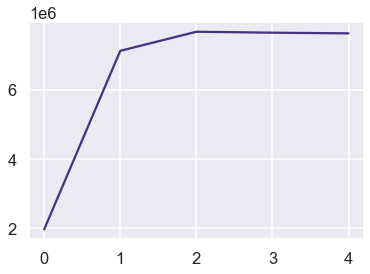

In [34]:
maintenance = fba['estimated_fluxes']['maintenance_reaction']
maintenance_target = fba['maintenance_target']['maintenance_reaction']
sns.lineplot([i for i in range(len(maintenance))], maintenance)

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

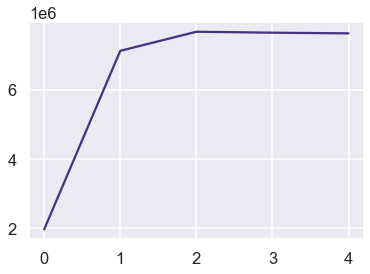

In [35]:
sns.lineplot([i for i in range(len(maintenance_target))], maintenance_target)

## Kinetic objective

In [36]:
fba.keys()

dict_keys(['estimated_fluxes', 'estimated_homeostatic_dmdt', 'target_homeostatic_dmdt', 'target_kinetic_fluxes', 'target_kinetic_bounds', 'estimated_exchange_dmdt', 'estimated_intermediate_dmdt', 'maintenance_target', 'solution_fluxes', 'solution_dmdt', 'solution_residuals', 'time_per_step'])

In [64]:
df1 = pd.DataFrame(fba['target_kinetic_fluxes'])
df1 = df1.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')

In [65]:
df4 = pd.DataFrame(fba['target_kinetic_bounds'])
df4 = df4.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='target')
df4 = pd.DataFrame(df4["target"].to_list(), columns=['lower', 'upper'])

df1 = df1.merge(df4, left_index=True, right_index=True)
df1.head()

,index,timestep,target,lower,upper
0,1.1.1.39-RXN,0,70892.0,70892.0,70892.0
1,1.1.1.83-RXN,0,1964.0,1964.0,1964.0
2,1.13.11.16-RXN,0,133.0,0.0,266.0
3,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,1250.0,39.0,5023.0
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18362//C...,0,1250.0,39.0,5023.0


In [66]:
kinetic_rxns = list(fba['target_kinetic_fluxes'].keys())
df2 = pd.DataFrame(fba['estimated_fluxes']).loc[:, kinetic_rxns]
df2 = df2.transpose().reset_index().melt(id_vars='index', var_name='timestep', value_name='update')
df2

,index,timestep,update
0,1.1.1.39-RXN,0,-2.0
1,1.1.1.83-RXN,0,-1.0
2,1.13.11.16-RXN,0,-19.0
3,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,-0.0
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18362//C...,0,1.0
...,...,...,...
1965,UNDECAPRENYL-DIPHOSPHATASE-RXN[CCO-CYTOSOL]-UN...,4,87.0
1966,URA-PHOSPH-RXN,4,1352.0
1967,UROGENIIISYN-RXN,4,310.0
1968,URPHOS-RXN__URPHOS-CPLX,4,147210.0


In [68]:
df3 = df1.merge(df2, left_on=['index', 'timestep'], right_on=['index', 'timestep'])
# df3[df3['timestep'] == 900].T
df3

for column in ["update", "target", "lower", "upper"]:
    df3[column] = df3[column].abs()
    df3[column] = np.log10(df3[column])

df3 = df3.replace([np.inf, -np.inf], 0)

df3['diff'] = df3['target'] - df3['update']

df3.head()

/Users/cyrus/.pyenv/versions/3.9.9/envs/viv/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,index,timestep,target,lower,upper,update,diff
0,1.1.1.39-RXN,0,4.850597,4.850597,4.850597,0.301030,4.549567
1,1.1.1.83-RXN,0,3.293141,3.293141,3.293141,0.000000,3.293141
2,1.13.11.16-RXN,0,2.123852,0.000000,2.424882,1.278754,0.845098
3,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18361//C...,0,3.096910,1.591065,3.700963,0.000000,3.096910
4,2.1.1.79-RXN-S-ADENOSYLMETHIONINE/CPD-18362//C...,0,3.096910,1.591065,3.700963,0.000000,3.096910


In [69]:
df3_subset = df3[df3['timestep'].isin([0, 1, 2, 10, 24, 100])]

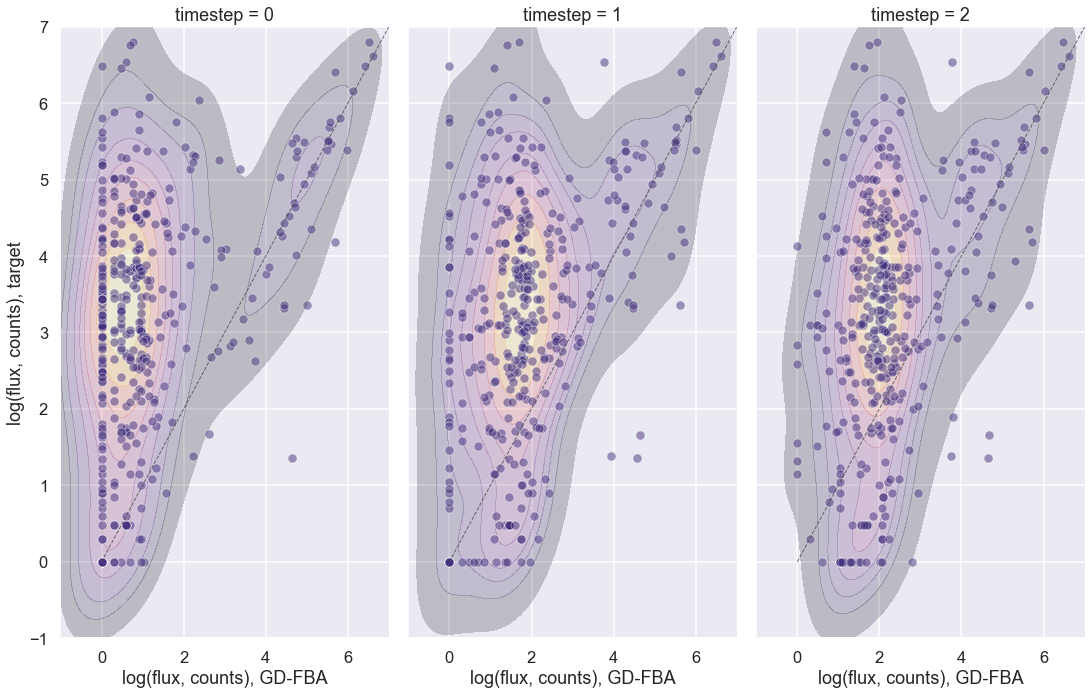

In [70]:
g = sns.FacetGrid(df3_subset, col="timestep", col_wrap=6, aspect=0.5, height=10, xlim=(-1,7), ylim=(-1,7))
g.map(sns.kdeplot, "update", "target", cmap="inferno", alpha=0.2, fill=True)
g.map(sns.scatterplot, "update", "target", alpha=0.5)
g.set_axis_labels("log(flux, counts), GD-FBA","log(flux, counts), target")

for ax in g.axes:
    ax.plot([0, 9], [0, 9], linewidth=1,  linestyle='--', color='.3', alpha=0.8)
    

plt.margins(0,0)

plt.savefig("out/fbagd/kinetics_high_weight_gd.jpg")

In [77]:
df3_subset = df3[df3['timestep'].isin([2])]

In [136]:
ranges = np.array(df3_subset.loc[:, ["lower","upper"]])
mid_dist = np.array([np.mean(ranges, axis=1), (ranges[:, 1] - ranges[:, 0])/2 + 0.1]).T


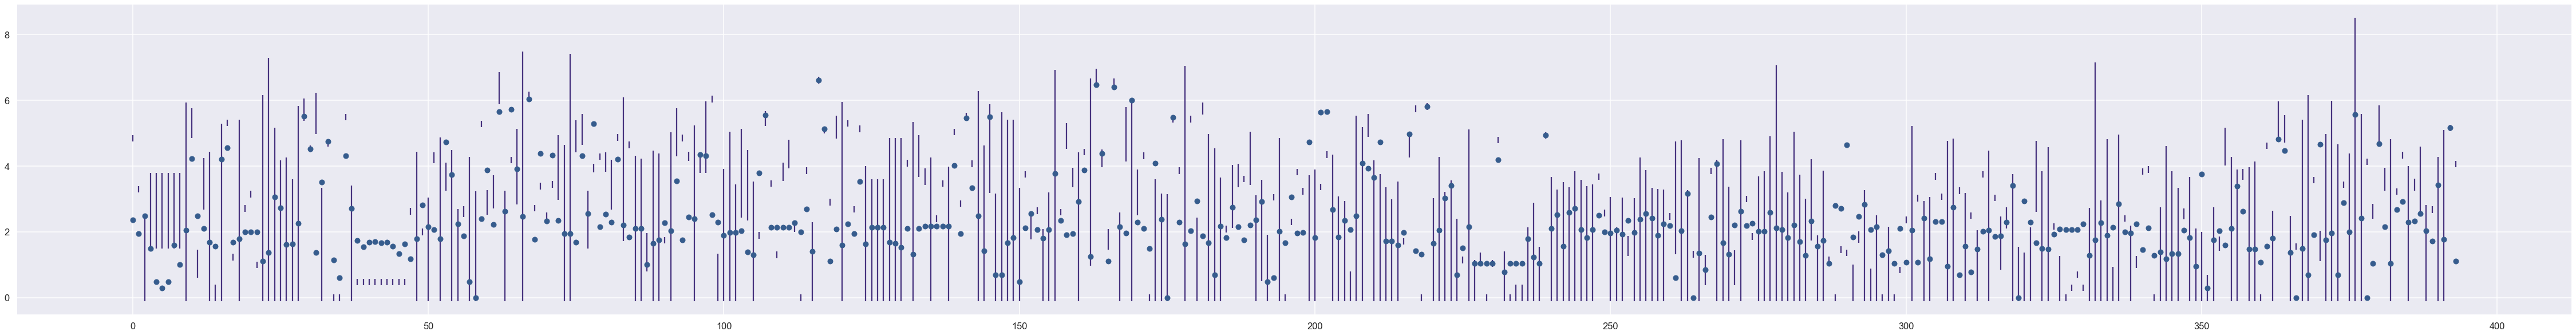

In [139]:
f, ax = plt.subplots(figsize=[80,10])

ax.errorbar(np.arange(0, len(df3_subset)), mid_dist[:, 0],  yerr=mid_dist[:, 1], linestyle="none")
ax.plot(np.arange(0, len(df3_subset)), np.array(df3_subset["update"]), linestyle="none", marker='o')

### Investigating limit to kinetic fluxes

That's weird, there seems to be some limit around a hundred molecules per time step. 

In [ ]:
weird_rxns = list(df3[(df3['timestep'].isin([4])) & (df3['diff'] > 1.5)]['index'])

In [ ]:
len(weird_rxns)

In [ ]:
for rxn in stoichiometry[:100]:
    if rxn['reaction id'] in weird_rxns:
        print(rxn['reaction id'], bulk.at[4, rxn['enzyme'][0]])

Complexes are present.

Are intermediates preventing dmdt? But fba should balance out those? Maybe the targets are just way off.

In [ ]:
# for rxn in stoichiometry:
#     if rxn['reaction id'] in weird_rxns:
#         target = fba['target_kinetic_fluxes'][rxn['reaction id']][4]
#         current = fba['estimated_fluxes'][rxn['reaction id']][4]
#         print(rxn['reaction id'],rxn['stoichiometry'],  f'{target} {current}', rxn['enzyme'][0],bulk.at[4, rxn['enzyme'][0]],'', sep='\n') #,bulk.at[4, rxn['enzyme'][0]]

In [ ]:
MHPCHYDROL-RXN

In [ ]:
intermediates = list(fba['estimated_intermediate_dmdt'].keys())

In [ ]:
for rxn in stoichiometry[:300]:
    if rxn['reaction id'] in weird_rxns:
        print(rxn['reaction id'], rxn['stoichiometry'])

In [ ]:
df3[(df3['timestep'].isin([4]))]

# Where's the large residuals coming from?

In [ ]:
df3['diff'] > 2

In [ ]:
df3['timestep'].isin([4])